In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf # tested on version 2.2.0
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['font.sans-serif'] = 'Arial'
from matplotlib import pyplot as plt
import paddle

# Set Numpy to display floats with 3 decimal places
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

2024-02-19 10:57:53.033282: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 10:57:53.503439: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-19 10:57:53.505058: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-19 10:57:56.655191: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# PADDLE

In [4]:
########
# Run predictions using PADDLE. This network requires predicted secondary
# structure (from PSIPRED) and predicted disorder (from IUPRED2, in both the
# short and long modes) as input in addition to the protein sequence. This
# model is the most accurate and should be used for predicted ADs in wild-type
# proteins.
########

# Load PADDLE models. There are 10 in total, and their individual predictions
# are averaged to obtain the final result.
pad = paddle.PADDLE()

Loading model split 1 of 10
Loading model split 2 of 10
Loading model split 3 of 10
Loading model split 4 of 10
Loading model split 5 of 10
Loading model split 6 of 10
Loading model split 7 of 10
Loading model split 8 of 10
Loading model split 9 of 10
Loading model split 10 of 10


10/10 [==============================] - 0s 11ms/step


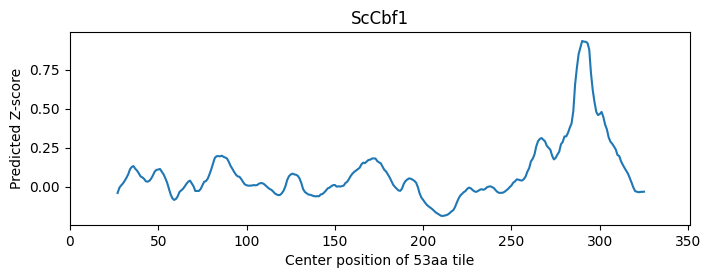

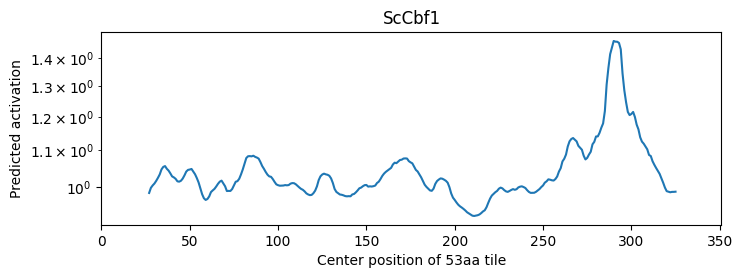

In [5]:
# As an example, let's predict on the S. cerevisiae Arg81 protein
with open('data/ScPho4.fa', 'r') as f:
    f.readline()
    prot = f.readline().strip()

# Load pre-computed secondary structure predicted by PSIPRED V4.
# When predicting across a large number of sequences, PSIPRED can be run
# without using BLAST, this speeds up secondary structure prediction.
seq, helix, coil = paddle.read_ss2('data/ScPho4_psipred.ss2')
assert prot == seq

# Load pre-computed disorder predicted by IUPRED2, in both
# the short and long modes.
prot, dis_short = paddle.read_iupred('data/20240305-iupred2-short-ScPho4.dis')
assert prot == seq
prot, dis_long = paddle.read_iupred('data/20240305-iupred2-long-ScPho4.dis')
assert prot == seq

# Run predictions on all 53 amino acid long tiles across the protein.
# This function requires matching protein sequence and secondary structure scores.
# Returns a Numpy array of size (protein_length-52) which gives the
# predicted activation Z-score for the 53aa tiles starting at positions
# 1, 2, 3, ..., protein_length-52.
# High-strength ADs can be called by finding >=5 consecutive positions with Z-score > 6.
# Medium-strength ADs can be called by finding >=5 consecutive positions with Z-score > 4.
preds = pad.predict_protein(prot, helix, coil, dis_short, dis_long)

# Plot predicted Z-scores based on the tiles' position in the protein.
plt.figure(figsize=(8,2.5))
plt.plot(np.arange(len(preds)) + (53+1)/2, preds)
plt.xlabel('Center position of 53aa tile')
plt.ylabel('Predicted Z-score')
plt.title('ScPho4')
plt.xlim(0,len(prot))
plt.show()

# Z-scores can be converted to fold-activation. This is only useful
# as a rough reference for activation in S. cerevisiae, as the
# fold-activation will vary between different experimental conditions.
pred_act = paddle.score2act(preds)

plt.figure(figsize=(8,2.5))
plt.semilogy(np.arange(len(pred_act)) + (53+1)/2, pred_act)
plt.xlabel('Center position of 53aa tile')
plt.ylabel('Predicted activation')
plt.title('ScPho4')
plt.xlim(0,len(prot))
plt.show()

In [14]:
# Create a DataFrame from the array
df = pd.DataFrame({'Zscore': preds})

# Specify the file name and location where you want to save the CSV
csv_file_name = "ScPho4zscore.csv"

# Save the DataFrame to a CSV file
df.to_csv(csv_file_name, index=False)

# PADDLE-noSS (fast)

In [5]:
########
# Run predictions using PADDLE-noSS. This network does not need predicted
# structure scores from PSIPRED and IUPRED2 and can therefore run very fast, and
# is nearly as accurate as PADDLE (with structure input). This model can be used
# when running predictions on a large number of mutant sequences, for example.
########

# Load PADDLE-noSS models. There are 10 in total, and their individual predictions
# are averaged to obtain the final result.
pad_noSS = paddle.PADDLE_noSS()

Loading model split 1 of 10
Loading model split 2 of 10
Loading model split 3 of 10
Loading model split 4 of 10
Loading model split 5 of 10
Loading model split 6 of 10
Loading model split 7 of 10
Loading model split 8 of 10
Loading model split 9 of 10
Loading model split 10 of 10


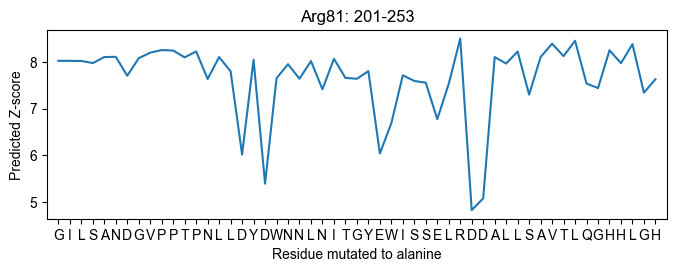

In [6]:
# Within an AD from Arg81, let's predict the effect on activation
# of mutating each residue to alanine one at a time.
with open('data/CaPho4.fa', 'r') as f:
    f.readline()
    prot = f.readline().strip()
AD = prot[200 : 253]

# construct list of scanning alanine mutant sequences
muts = []
for i in range(len(AD)):
    mut = list(AD)
    mut[i] = 'A'
    muts.append(''.join(mut))
    
# Run predictions. This function takes a list of 53aa protein sequences (strings)
# as input and returns an array of the same size of predicted activation Z-scores.
# This function can also take a single 53aa sequence as input, but running many
# sequences at once in batch will be faster than individually.
preds = pad_noSS.predict(muts)

# Plot the results based on the amino acid position that was mutated to alanine.
plt.figure(figsize=(8,2.5))
plt.plot(preds)
plt.xticks(np.arange(len(AD)), list(AD))
plt.xlim(-1, len(AD))
plt.title('Arg81: 201-253')
plt.xlabel('Residue mutated to alanine')
plt.ylabel('Predicted Z-score')
plt.show()

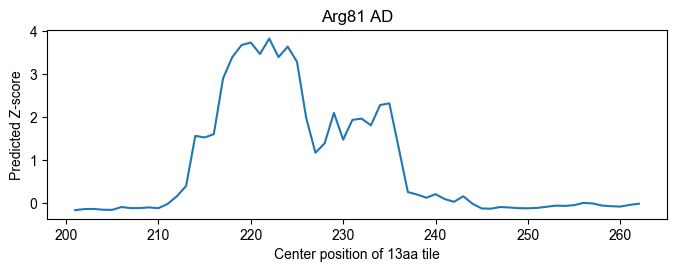

In [7]:
# Within an AD from Arg81, let's find core AD regions by predicting
# the activation Z-scores of 13aa tiles. To predict on sequences
# shorter than 53aa, we need to embed them inside 'neutral' sequences
# (i.e. with no intrinsic activation capacity)
AD_start = 194
AD_stop = 256

# Generate neutral background sequences by randomly sampling from AGSTNQV
# residues. To minimize the effect of the background sequence, it's good
# to use many of them and average the results.
np.random.seed(42)
bg_prots = [''.join(np.random.choice(list('AGSTNQV'), size=53)) for _ in range(10)]

# Run predictions. This takes a list of protein sequences which can be 53aa or shorter
# and a list of background sequences to embed in.
preds = pad_noSS.predict_subsequences([prot[i:i+13] for i in range(AD_start, AD_stop)], bg_prots)

# Plot the results based on the 13aa tiles' position in the protein
plt.figure(figsize=(8,2.5))
plt.plot(np.arange(AD_start, AD_stop) + (13+1)/2, preds)
plt.xlabel('Center position of 13aa tile')
plt.ylabel('Predicted Z-score')
plt.title('Arg81 AD')
plt.show()